# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

## modelling the Launch Segment

imitating ascent characteristics from Apollo return flights

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

Segmented flight: vertical rise, orbit injection

In [215]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from io import StringIO
from csv import writer 

In [97]:
# set launch carrier properties
# EL3 - European Large Logistics Lander
mass_dry  = 1600 # kg
mass_full = 8500 # kg
mass_fuel = mass_full - mass_dry # kg
m_flow = 10 # [kg/s] massflow
I_sp = 453 # [s] specific impulse
g_0 = 9.80665 # [kg/s²] standard gravity
EEV = I_sp * g_0 # [m/s] effective exhaust velocity


r_moon = 1737400    # [m] volumetric mean radius of the moon
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant



# acceleration direction from propulsion
#         0°
#         │                
# 270° ───┼─── 90°     reference angle from vertical axis, perpendicular to lunar surface
#         │
#        180°

def angle(vec,rad=False):
    
    vector_1 = [0, 1, 0]
    vector_2 = vec
    
    if np.linalg.norm(vector_2) == 0: return None

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    if vec[0]<0:
        angle = 2*np.pi - angle
    
    if rad: return angle
    return np.rad2deg(angle)
    

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    
    # verify
    #print(f'vector angle is {angle(vec)}°')
    
    return vec

def plot_vector(vec):
    
    plt.figure(figsize=(3, 3), dpi=50)
    
    # reference vector
    xpoints = np.array([0, 0])
    ypoints = np.array([0, 1])
    plt.plot(xpoints, ypoints, '--', color = 'b')
    
    xpoints = np.array([0, vec[0]])
    ypoints = np.array([0, vec[1]])
    plt.plot(xpoints, ypoints, color = 'r')
    
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    #unit circle
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), linewidth=2)
    
    plt.axis('off')
    plt.show()

In [323]:
def norm(vec):
    # r = length of pos vector
    return np.linalg.norm(vec)

def r_sys(vec, pos):

    alpha = angle(pos,rad=True)

    rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

    v = np.array([vec[0], vec[1]], dtype=np.float64)

    v2 = np.dot(rot, v)
    
    return np.array([v2[1], v2[0], vec[2]], dtype=np.float64)
    
    
def altitude(pos):
    r = norm(pos)
    return r - r_moon

def orbital_velocity(altitude):
    return np.sqrt((G * m_moon)/(r_moon + alt))

def acc_grav_moon(pos):
    r = norm(pos)
    r_val = G * (m_moon/(r**2))
    e_r = -(pos / norm(pos))
    
    return (e_r * r_val)

def acc_centrifugal(pos,vel):
    r = norm(pos)
    v = r_sys(vel,pos)[1] # vel portion that is ⊥ to r -> phi_val
    r_val = (v**2)/(r)
    e_r = (pos / norm(pos))
    
    return (e_r * r_val)

print('test acc_grav_moon(r) function:',acc_grav_moon(np.array([0,r_moon,0])),'[m/s²]','vs. 1.622 [m/s²] expected on surface')

def acc_propulsion(m):
    F_thrust = m_flow * EEV
    return F_thrust / m
    
print('test acc_propulsion(m) function:',acc_propulsion(mass_full),'[m/s²]')

def hover_dir(pos,vel,m):
    acc_grav = acc_grav_moon(pos)
    acc_cent = acc_centrifugal(pos,vel)
    #plot_vector(acc_grav)
    #plot_vector(acc_cent)

    acc_r = acc_grav #+ acc_cent
    
    #print(acc_grav,'+',acc_cent,'=',acc_r)
    #plot_vector(acc_r)
    
    abs_acc_propulsion = acc_propulsion(m)
    
    e_r = (pos / norm(pos))
    e_r_angle = angle(e_r)
    e_phi = vec_from_angle(e_r_angle + 90)
    
    # Thrust vector T = acc_r + acc_phi
    acc_phi = e_phi * (np.sqrt(norm(acc_r)**2 + abs_acc_propulsion**2))
    T = acc_phi - acc_r
    
    hover_dir = T / norm(T)
    #plot_vector(hover_dir)
    
    return hover_dir
    
hover_dir(np.array([100000,r_moon,0]),np.array([5000,1000,0]),8500)

    
    

test acc_grav_moon(r) function: [-0.         -1.62426548 -0.        ] [m/s²] vs. 1.622 [m/s²] expected on surface
test acc_propulsion(m) function: 5.226367588235294 [m/s²]


array([0.97362419, 0.2281577 , 0.        ])


┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘


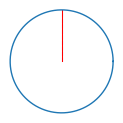

Phase 1 finished at 12.0 s

┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘


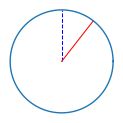

Phase 2 finished at 14.0 s

┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘


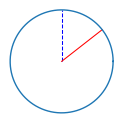

Phase 3 finished at 16.0 s

┌───────────┬──────────────────────────────────┐
│ Phase 4.0 │   80° burn, set target_altitude  │
└───────────┴──────────────────────────────────┘


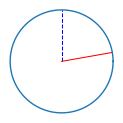

altitude(pos): 451.84319334849715 target_altitude: 2000 estimated_alt_gain: 833.0710866693883
True
Phase 4.0 finished at 44.7 s
> Altitude 1666.9282478541136 m reached
> Orbital velocity 1679.0753105688627 m/s needed
20.29215759946614 s 333.7737316678208 m altitude gain

┌───────────┬────────────────────────────┐
│ Phase 4.1 │   90° burn until vel_r = 0 │
└───────────┴────────────────────────────┘


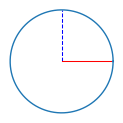

Phase 4.1 finished at 65.6 s
> Altitude 2008.3850932519417 m reached
> Orbital velocity 1678.910495938909 m/s needed

┌───────────┬─────────────────────────────────────────────┐
│ Phase 4.2 │   orbit injection, constant altitude burn   │
└───────────┴─────────────────────────────────────────────┘
from 74.86091092083403°


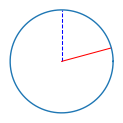

to 85.5665352789326°


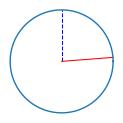

Phase 4 finished at 282.2 s

┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘


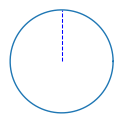


├───────────────── FINISHED ──────────────────┤

          mass [kg]  altitude [m]     pos_x [m]     pos_y [m]  pos_z [m]  vel_r [m/s]  vel_phi [m/s]   vel_x [m/s]  vel_y [m/s]  vel_z [m/s]  acc_r [m/s²]  acc_phi [m/s²]  acc_x [m/s²]  acc_y [m/s²]  acc_z [m/s²]  dir_n [°]
time [s]                                                                                                                                                                                                                       
0.0          8500.0      0.000000  0.000000e+00  1.737400e+06        0.0     0.000000   0.000000e+00  0.000000e+00     0.000000          0.0      0.000000    0.000000e+00  0.000000e+00      0.000000           0.0   0.000000
0.1          8499.0      0.000000  0.000000e+00  1.737400e+06        0.0     0.180105   1.600114e-17  1.600114e-17     0.180105          0.0      3.602102    3.200227e-16  3.200227e-16      3.602102           0.0   0.000000
0.2          8498.0      0.036021  3.200227e-18  1.737

In [369]:
# SIMULATION
    
# setup parameters
t_step = 0.1 # [s] time for one simulation step
t_step = np.array(t_step, dtype=np.float64) 
digit_precision = 3

time = np.array(0, dtype=np.float64)

# cartesian coordinates - 3D
#         y   z
#         │ /              
#      ───┼─── x    [x,y,z]
#       / Moon       
# point of origin = moon center mass point

# Spacecraft properties
# mass
m = mass_full  # [kg]

# position
pos = np.array([0,r_moon,0], dtype=np.float64) # [m]

# velocity
#add ground speed vel
vel = np.array([0,0,0], dtype=np.float64) # [m/s]

# acceleration
acc = np.array([0,0,0], dtype=np.float64) # [m/s²]

# engine toggle
engine_on = True
# engine acc direction
dir_n = vec_from_angle(0)

# pandas df for logging
# to increase appending speed, rows are written into memory then read back in pandas df
output = StringIO()
csv_writer = writer(output)

csv_writer.writerow(['time [s]','mass [kg]','altitude [m]','pos_x [m]','pos_y [m]','pos_z [m]','vel_r [m/s]','vel_phi [m/s]','vel_x [m/s]','vel_y [m/s]','vel_z [m/s]','acc_r [m/s²]','acc_phi [m/s²]','acc_x [m/s²]','acc_y [m/s²]','acc_z [m/s²]','dir_n [°]'])

def write_data_row():
    csv_writer.writerow([time,m,altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[0],r_sys(vel,pos)[1],vel[0],vel[1],vel[2],r_sys(acc,pos)[0],r_sys(acc,pos)[1],acc[0],acc[1],acc[2],angle(dir_n)])

write_data_row() # inital values at index 0 at time 0

def log(x=1):
    # logging results only every x seconds
    if (time*1000)%(x) == 0:
        write_data_row()


# Velocity Verlet - numerical solution to differential equation

def phys_sim_step():
    
    global time, pos, vel, acc, m, dir_n
    
    # one sim step BEGIN
    ###############################
    new_pos = pos + vel*t_step + acc*(t_step*t_step*0.5)
    new_acc = (dir_n * acc_propulsion(m)) + acc_grav_moon(pos)
    new_vel = vel + (acc+new_acc)*(t_step*0.5)    
    
    if engine_on: new_mass = m - (m_flow * t_step)
    else: new_mass = m
    
    pos = new_pos
    vel = new_vel
    acc = new_acc
    m = new_mass
    
    time = np.around(time + t_step,digit_precision)

    ###############################
    # one sim step END
    

# Simulation execution


target_altitude = 2000 # [m]


print('''
┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(0)
plot_vector(dir_n)

# stop condition: time

while time < 12: 
    
    phys_sim_step()
    
    log(1) # log every x [ms]
        

phase1_end = time
print(f'Phase 1 finished at {phase1_end} s')
        
print('''
┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(38)
plot_vector(dir_n)

# stop condition: time
time_now = time
while time < time_now + 2: 
    
    phys_sim_step()
    
    log(1) # log every x [ms]

phase2_end = time 
print(f'Phase 2 finished at {phase2_end} s')
    
print('''
┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(52)
plot_vector(dir_n)

# stop condition: time
time_now = time
while time < time_now + 2: 
    
    phys_sim_step()
    
    log(1) # log every x [ms]
    
phase3_end = time 
print(f'Phase 3 finished at {phase3_end} s')



# Phase 4.0: Orbit injection - bring vel_r = 0
print('''
┌───────────┬──────────────────────────────────┐
│ Phase 4.0 │   80° burn, set target_altitude  │
└───────────┴──────────────────────────────────┘''')

dir_n = vec_from_angle(80)
plot_vector(dir_n)

# stop condition: setting target_altitude
phase41_time = r_sys(vel,pos)[0] / norm(acc_grav_moon(pos))
estimated_alt_gain = 0.5 * r_sys(vel,pos)[0] * phase41_time
print('altitude(pos):',altitude(pos),'target_altitude:',target_altitude,'estimated_alt_gain:',estimated_alt_gain)
print((altitude(pos) < (target_altitude - estimated_alt_gain)))

while (altitude(pos) < (target_altitude - estimated_alt_gain)): 
    
    phase41_time = r_sys(vel,pos)[0] / norm(acc_grav_moon(pos))
    estimated_alt_gain = 0.5 * r_sys(vel,pos)[0] * phase41_time
    
    phys_sim_step()
    
    log(1) # log every x [ms]
    
phase40_end = time 
print(f'Phase 4.0 finished at {phase40_end} s')

alt = altitude(pos)
print(f'> Altitude {alt} m reached')
print(f'> Orbital velocity {orbital_velocity(alt)} m/s needed')
print(phase41_time,'s',estimated_alt_gain,'m altitude gain')


# Phase 4.1: Orbit injection - bring vel_r = 0
print('''
┌───────────┬────────────────────────────┐
│ Phase 4.1 │   90° burn until vel_r = 0 │
└───────────┴────────────────────────────┘''')

dir_n = vec_from_angle(90)
plot_vector(dir_n)

# stopping condition: radial velocity

while r_sys(vel,pos)[0] > 0: 
    
    phys_sim_step()
    
    log(1) # log every x [ms]
    
phase41_end = time 
print(f'Phase 4.1 finished at {phase41_end} s')

alt = altitude(pos)
print(f'> Altitude {alt} m reached')
print(f'> Orbital velocity {orbital_velocity(alt)} m/s needed')

# Phase 4: Orbit injection
print('''
┌───────────┬─────────────────────────────────────────────┐
│ Phase 4.2 │   orbit injection, constant altitude burn   │
└───────────┴─────────────────────────────────────────────┘''')

dir_n = hover_dir(pos,vel,m)
#dir_n = vec_from_angle(83)
print(f'from {angle(dir_n)}°')
plot_vector(dir_n)

while r_sys(vel,pos)[1] < orbital_velocity(alt): # orbital velocity, vel_phi
    
    dir_n = hover_dir(pos,vel,m)
    alt = altitude(pos)

    phys_sim_step()
    
    log(1) # log every x [ms]
    
dir_n = hover_dir(pos,vel,m)

print(f'to {angle(dir_n)}°')
plot_vector(dir_n)


phase4_end = time
print(f'Phase 4 finished at {phase4_end} s')

print('''
┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘''')

dir_n =  np.array([0,0,0], dtype=np.float64)
plot_vector(dir_n)
engine_on = False

now_time = time

while time < now_time + 0:
    
    phys_sim_step()
    
    log(1000) # log every full x [ms]


print('''
├───────────────── FINISHED ──────────────────┤
''')


# load pandas df back from memory
output.seek(0) # we need to get back to the start of the StringIO
df = pd.read_csv(output)
df = df.set_index('time [s]')
print(df)

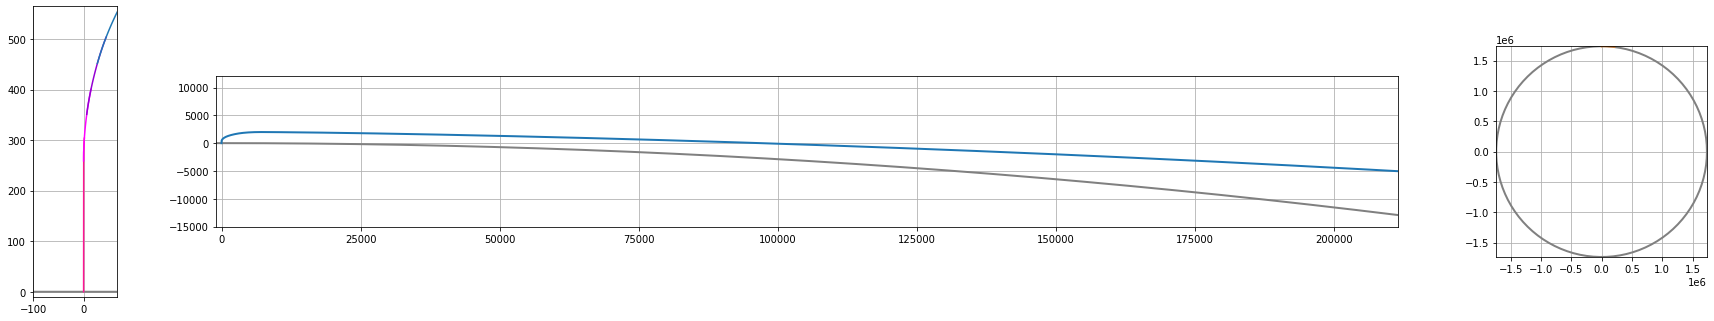

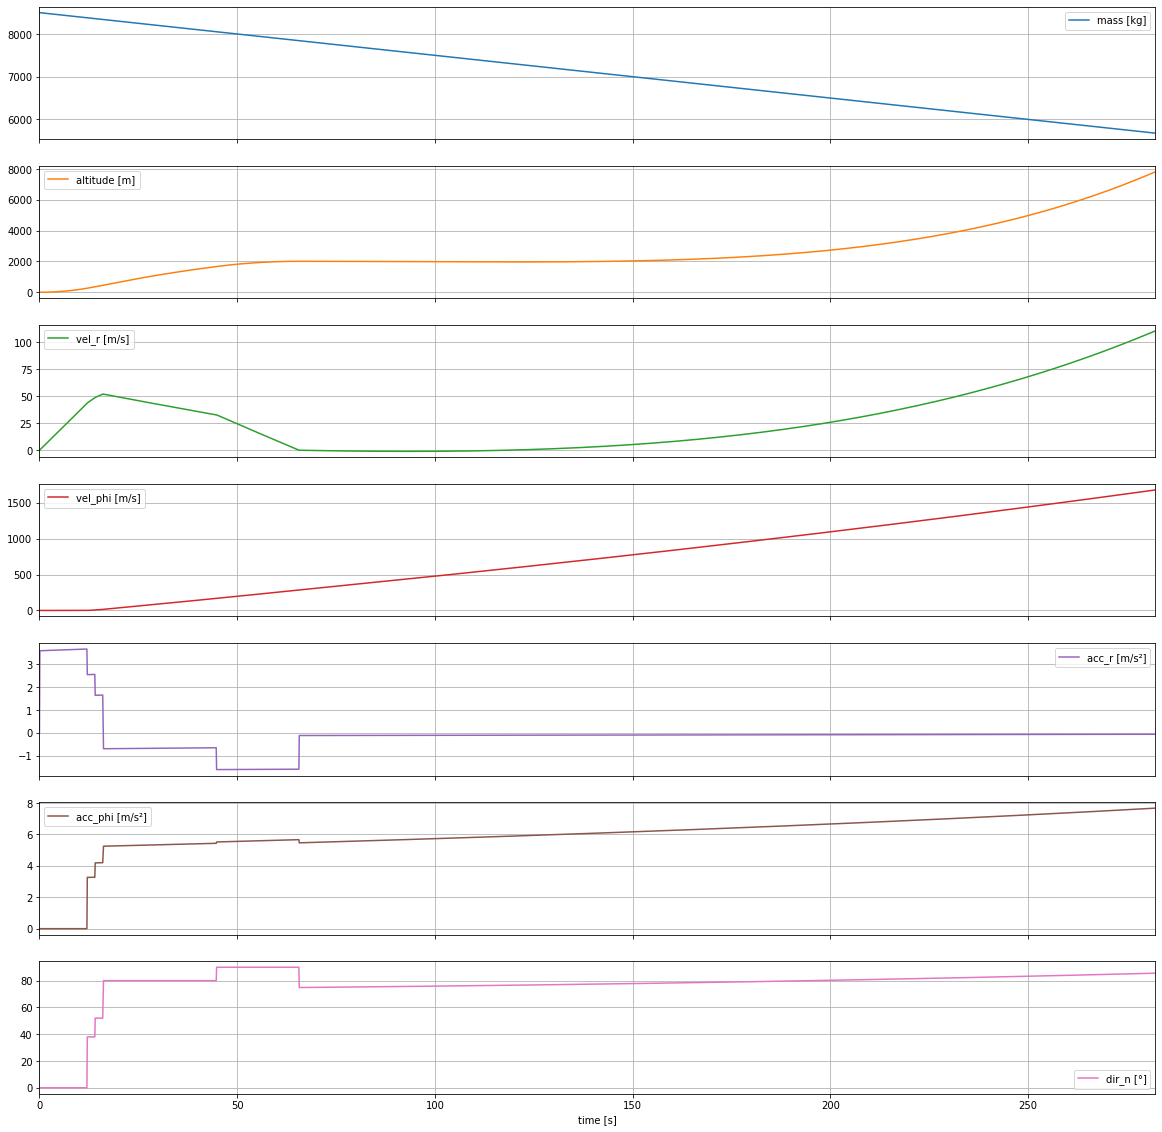

In [370]:
# plot path cartesian
dpi = 72

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10),dpi=dpi)


# Create 2x2 sub plots
gs = gridspec.GridSpec(ncols=3, nrows=1,width_ratios=[1,14,2.5])

pl.figure(figsize=(30,10))


# left
ax = pl.subplot(gs[0, 0]) # row 0, col 0

offset_y = r_moon
# moon surface
t = np.linspace(0.49*np.pi,0.51*np.pi,1000)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t)-offset_y,color='grey', linewidth=2)

xpoints = df.loc[0.0:phase3_end+2]['pos_x [m]']
ypoints = df.loc[0.0:phase3_end+2]['pos_y [m]']


max_x = np.max(xpoints)
max_y = np.max(ypoints-offset_y)
min_x = np.min(xpoints)
min_y = np.min(ypoints-offset_y)

pad_y = 1e1
pad_x = 1e2

ax.set_xlim(min_x-pad_x, max_x)
ax.set_ylim(min_y-pad_y, max_y+pad_y)

ax.set_aspect('equal', adjustable='box')
ax.grid(True)
pl.plot(xpoints[:round(phase1_end+1)],ypoints[:round(phase1_end+1)]-offset_y                                  , color='deeppink') # phase 1
pl.plot(xpoints[round(phase1_end):round(phase2_end+1)],ypoints[round(phase1_end):round(phase2_end+1)]-offset_y, color='magenta') # phase 2
pl.plot(xpoints[round(phase2_end):round(phase3_end+1)],ypoints[round(phase2_end):round(phase3_end+1)]-offset_y, color='darkviolet') # phase 3
pl.plot(xpoints[round(phase3_end):slice_n],ypoints[round(phase3_end):slice_n]-offset_y                        ,color='tab:blue') # phase 4

#middle
ax = pl.subplot(gs[0, 1])

t = np.linspace(0.45*np.pi,0.51*np.pi,1000)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t)-offset_y,color='grey', linewidth=2)

xpoints = df.loc[:phase4_end]['pos_x [m]']
ypoints = df.loc[:phase4_end]['pos_y [m]']

max_x = np.max(xpoints)
max_y = np.max(ypoints-offset_y)
min_x = np.min(xpoints)
min_y = np.min(ypoints-offset_y)

pad_y = 1e4
pad_x = 1e3

ax.set_xlim(min_x-pad_x, max_x)
ax.set_ylim(min_y-pad_y, max_y+pad_y)

ax.set_aspect('equal', adjustable='box')
ax.grid(True)
pl.plot(xpoints,ypoints-offset_y,color='tab:blue', linewidth=2) # phase 4


# right
ax = pl.subplot(gs[0, 2]) # row 0, col 1
pl.plot([0,1])

# moon surface
t = np.linspace(0,2*np.pi,100)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t),color='grey', linewidth=2)

xpoints_prop = df.loc[phase4_end:]['pos_x [m]']
ypoints_prop = df.loc[phase4_end:]['pos_y [m]']
pl.plot(xpoints_prop,ypoints_prop, color='tab:green', linewidth=1) # propagate

xpoints = df.loc[0.0:phase4_end]['pos_x [m]']
ypoints = df.loc[0.0:phase4_end]['pos_y [m]']
pl.plot(xpoints,ypoints, linewidth=2 ) # start

ext = np.max(np.abs([ df['pos_x [m]'],df['pos_y [m]']]))

ax.set_ylim(-ext, ext)
ax.set_xlim(-ext, ext)
ax.set_aspect('equal', adjustable='box')
ax.grid(True)


#plt.axis('off')
plt.show()

# plot result properties graphs

df[['mass [kg]','altitude [m]','vel_r [m/s]','vel_phi [m/s]','acc_r [m/s²]','acc_phi [m/s²]','dir_n [°]']].plot(subplots=True,figsize=(20,20),grid=True,xlim=[0, df.index[-1]])
#df.plot(subplots=True,figsize=(20,25))
plt.show()

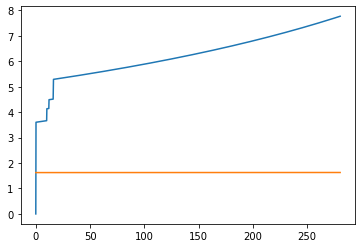

In [214]:
n = len(df['acc_x [m/s²]'].values)
result = np.zeros(n)

acc_x_val = df['acc_x [m/s²]'].values
acc_y_val = df['acc_y [m/s²]'].values

for i in range(n):
    x_vec = acc_x_val[i] * np.array([1,0,0])
    y_vec = acc_y_val[i] * np.array([0,1,0])
    result[i] = norm(x_vec+y_vec)

ypoints = result
xpoints = df.index

plt.plot(xpoints,ypoints)

def acc_grav_moon_2(alt):
    r = alt + r_moon
    r_val = G * (m_moon/(r**2))
    
    return r_val

#verify acc_x acc_y correct

alt = df['altitude [m]'].values
result = np.zeros(n)


for i in range(n):
    result[i]= acc_grav_moon_2(alt[i])
    

ypoints = result
xpoints = df.index

plt.plot(xpoints,ypoints)
plt.show()
# > pass, correct

#verify acc_x acc_y transform > acc_r correct





# STK

In [ ]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [18]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [3]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [21]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

agi.stk12.stkobjects.AgStkObjectRoot

In [5]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [7]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [8]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [10]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [15]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [16]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

Result image resolution: 73.0 x 37.0
number of calculations: 2701.0

73 [-180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]

37 [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75, -80, -85, -90]


  0%|          | 0/2701.0 [00:00<?, ?it/s]

STKRuntimeError: Position central bodies were not equivalent.

### save result in xArray

In [7]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

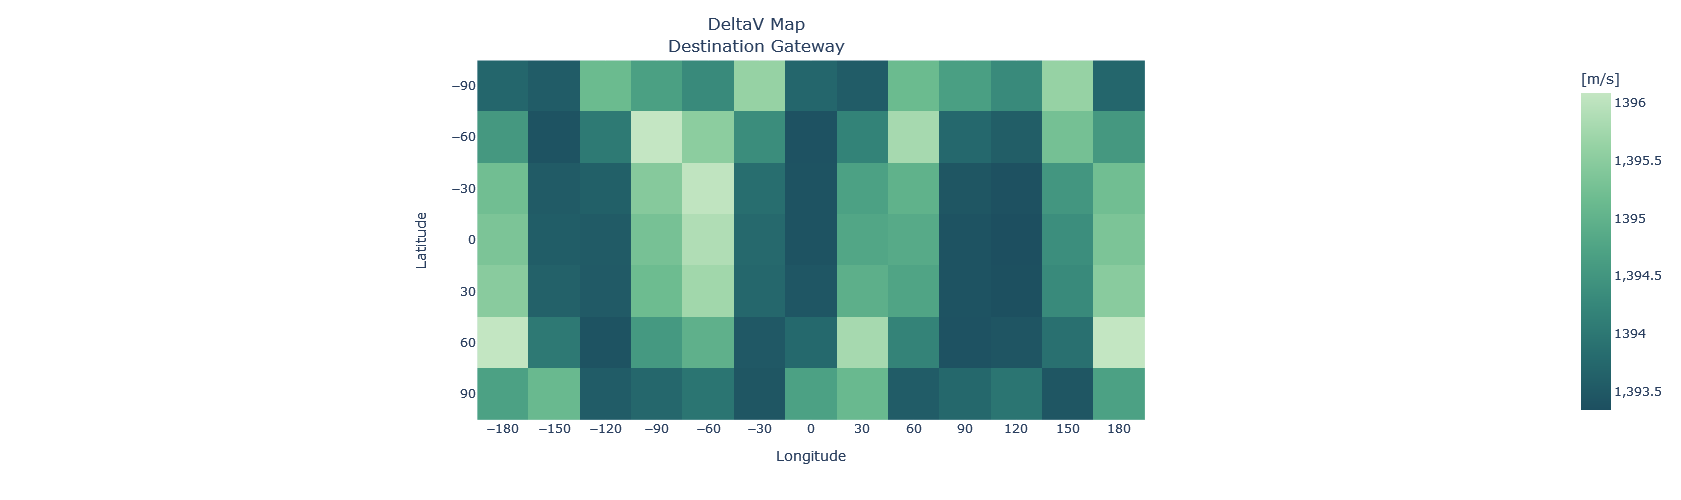

In [14]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK